In [38]:
%load_ext autoreload
%autoreload 2
import se2_flow
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


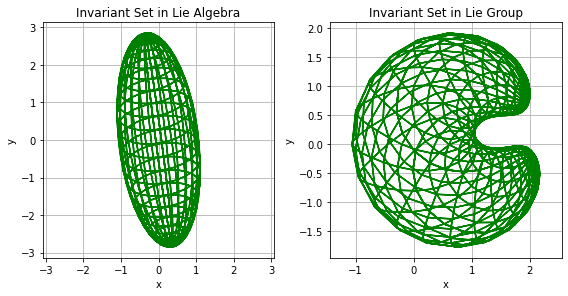

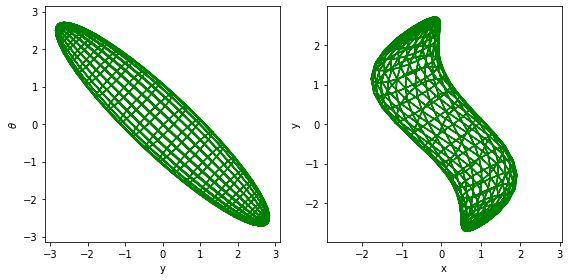

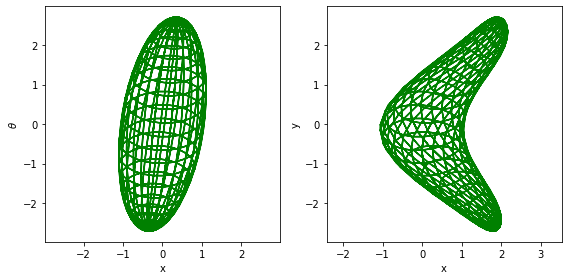

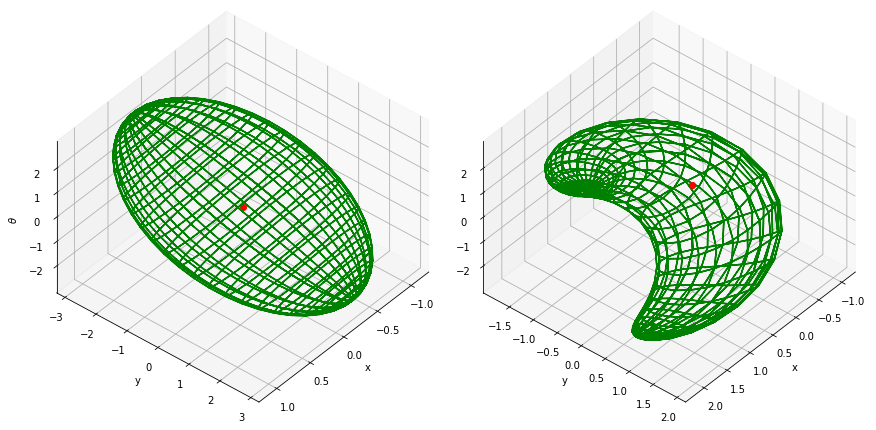

In [39]:
se2_flow.plot_invariant_set()

In [41]:
sol

{'cost': 2.7037467746804076,
 'prob': <Semidefinite Program>,
 'mu1': 1.9756083154466253,
 'mu2': 0.7281384592337821,
 'P': array([[ 2.427, -0.089, -0.393],
        [-0.089,  2.086,  2.022],
        [-0.393,  2.022,  2.366]]),
 'alpha': (1.061606813867125+0j),
 'gam': <1×1 Real Linear Expression: mu_1 + mu_2>}

# Flow Pipes Simulation

In [43]:
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol1 = se2_flow.find_se2_invariant_set() # u, v, w1, w2

ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e0 = se2_flow.se2_log(np.array([0, 0, -np.pi/10]))

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)

#TEB_small = circ_inv(1.476) # HJB w/ control bound [-pi,pi]
#L_small = circ_inv(1.4487) # lyapunov w/ small theta_max
#L_large = circ_inv(2.1136) # lyapunov w/ large theta_max
#flow_pipes_Ls, intervalhull_Ls, nom, ang = flowpipes(res,L_small,t, n)
#flow_pipes_Ll, intervalhull_Ll, nom = flowpipes(xr,r_large,t, n)
#flow_pipes_Hs, intervalhull_Hs, nom, ang = flowpipes(res,TEB_small,t, n)
#flow_pipes_Hl, intervalhull_Hl, nom = flowpipes(xr,TEB,t, n)

NameError: name 'take' is not defined

Text(0, 0.5, 'y')

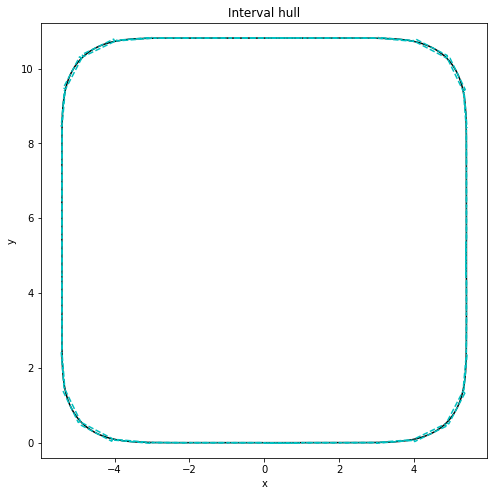

In [15]:
# interval hull
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ls = ax.plot(intervalhull_Ls[facet][:,0], intervalhull_Ls[facet][:,1], color='m', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Interval hull')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_Ls[0]], ['nominal', 'interval hull'], loc=1);

Text(0, 0.5, 'y')

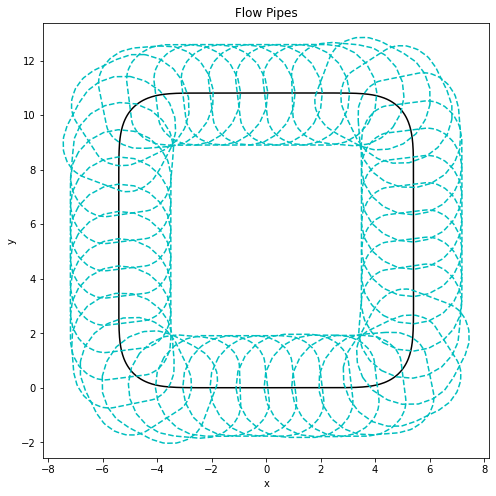

In [16]:
# flow pipes
plt.figure(figsize=(8,8))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
title('Flow Pipes')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

# Trajectories simulation

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


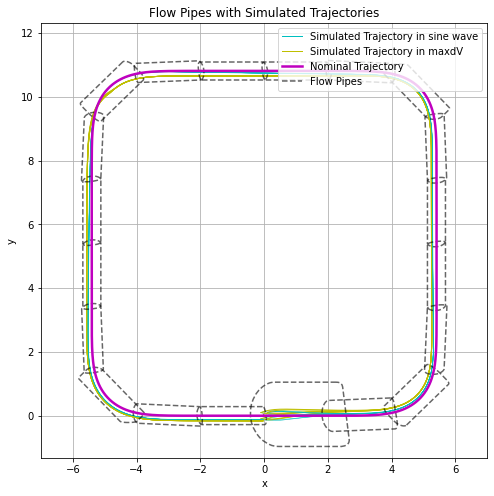

In [17]:
# small distrubance
freq = [0.02] #, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 20 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e = []
V=[]

for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='maxdV', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = 1, color = 'y')
                        
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2.5)

plt.axis('equal')
plt.xlim([-7, 7])
plt.ylim([-3, 14])
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

In [18]:
%load_ext autoreload
%autoreload 2

[ 0.          0.         -0.31415927]


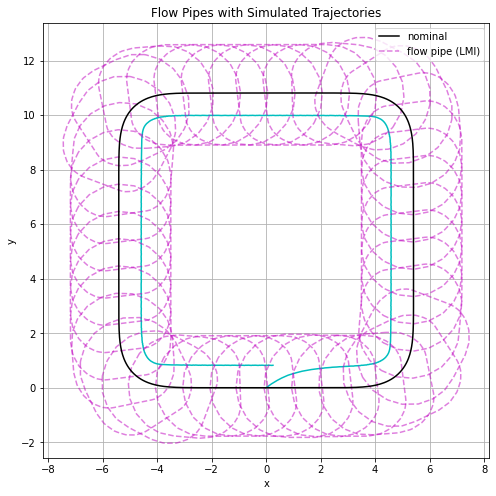

In [19]:
import SE2_with_Disturbance as SE_Dist

# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
freq = [0.02]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


init_e = array([[0, 0, -pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = SE_Dist.simulate(tf=40, freq_d=i, w1_mag=w1, w2_mag=w2, x0=init_e[0], y0=init_e[1], theta0=init_e[2], dist='maxdV', sol= sol1, use_approx=False)
    SE_Dist.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
title('Flow Pipes with Simulated Trajectories')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

# Application Example

In [20]:
V2 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])
P2 = Polytope(V2)
p4 = (4, 6)
P3 = P2*1.5 + (0,8.5)
P4 = P2 + p4
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P5 = 0.5*rot_mat5*P3 -(1, 0)

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


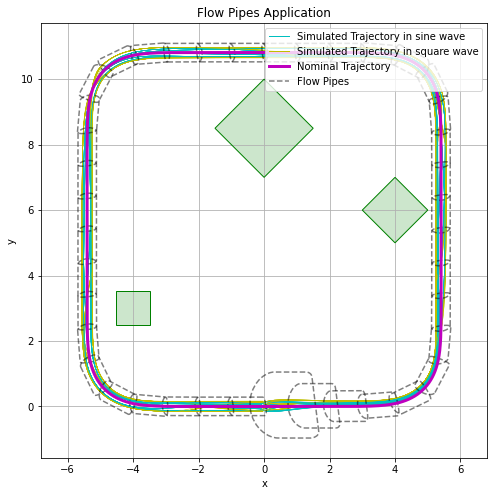

In [21]:
freq = [0.02, .04, .06, .08, .01]
res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y')
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

P4.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 3)

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


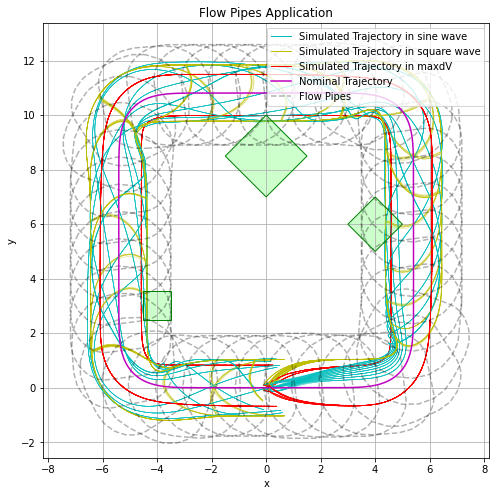

In [22]:
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
#freq = [0.02]

res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = SE_Dist.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


for theta0 in np.linspace(-pi/10, pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    r3 = SE_Dist.simulate(40, i, w1, w2, x0, y0, theta0, dist='maxdV', sol= sol1, use_approx=False)

                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        SE_Dist.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        SE_Dist.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                        SE_Dist.plot_simulated(r3, name='maxdV', legend=True, save=False, linewidth = 1, color = 'r')
                    else:
                        SE_Dist.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c', alpha = 0.5)
                        SE_Dist.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y', alpha = 0.5)
                        SE_Dist.plot_simulated(r3, name='', legend=False, save=False, linewidth = .5, color = 'r', alpha = 0.5)
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_log(array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.3)

P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
title('Flow Pipes Application')
xlabel('x')
ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

In [23]:
from math import pi, cos, sin, sqrt
from pyobb.obb import OBB

# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

In [24]:
def flowpipes3d(res, points, tf, n):
    t_vect = np.arange(0, tf, 0.05)
    
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    
    y = array([x_r,y_r]).T
    
    nom = np.append(y,zeros((y.shape[0],1)), axis = 1) # n*3 (x-y direction) ###########
    
    # bound 
    #theta_circ = np.linspace(0, 2*np.pi, 30)
    #circ = array([1.5*np.cos(theta_circ), 1.5*np.sin(theta_circ), ones(30)]).T # circle in 3D
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t_vect)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*3
        
        # interval hull
        obb = OBB.build_from_points(nom_i)
        
        # minkowski sum
        P1 = Polytope(obb.points) # interval hull
        P2 = Polytope(points.T) # invariant set
        P = P1+P2 # sum
        
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
        
    return flowpipes, intervalhull, nom

In [25]:
n2 = 40
flow_pipes3d_s, intervalhull_s, nom = flowpipes3d(ref,exp_points,t, n2)

Text(0.5, 0.5, 'y')

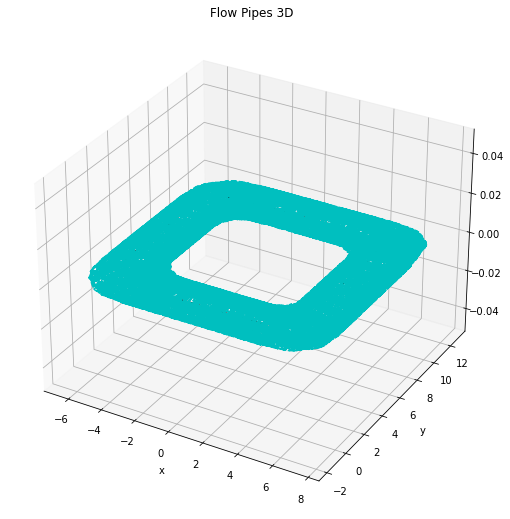

In [26]:
plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n2):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')

title('Flow Pipes 3D')
xlabel('x')
ylabel('y')